In [35]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install  numpy scipy scikit-learn h5py pillow requests six chardet idna pyopenssl pysocks wheel setuptools sklearn==0.0 torchfile==0.1.0 visdom==0.1.8.3 websocket-client==0.47.0

In [37]:
%cd /content/drive/MyDrive/visdial-rl/


/content/drive/MyDrive/visdial-rl


In [38]:
!pip install markdown2

In [39]:
# Evaluation Script for VisDial in Jupyter Notebook Style (Using Matplotlib instead of Visdom)

import os
import gc
import random
import pprint
import warnings
from time import gmtime, strftime
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from six.moves import range
from markdown2 import markdown
import matplotlib.pyplot as plt

from dataloader import VisDialDataset
from eval_utils.dialog_generate import dialogDump
from eval_utils.rank_answerer import rankABot
from eval_utils.rank_questioner import rankQBot, rankQABots
from utils import utilities as utils
from utils.visualize import MatplotlibVisualize

warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
# ----------- Visualization Helper (Matplotlib) -----------
def line_plot(x, y, title, ylabel, xlabel='Iterations'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [40]:
# ----------- Configuration (Manual setup instead of command line) -----------
params = {
    'inputImg': 'data/visdial/data_img.h5',
    'inputQues': 'data/visdial/chat_processed_data_gencaps.h5',
    'inputJson': 'data/visdial/chat_processed_params.json',
    'cocoDir': '/content/drive/MyDrive/visdial-rl/data/visdial/data_img.h5',
    'cocoInfo': '/content/drive/MyDrive/visdial-rl/coco/captions_val2014.json',
    'verbose': 1,
    'savePath': 'checkpoints/',
    'saveName': '',
    'continue': False,
    'enableVisdom': 0,
    'visdomEnv': '',
    'visdomServer': '127.0.0.1',
    'visdomServerPort': 8893,
    'randomSeed': 32,
    'imgEmbedSize': 300,
    'imgFeatureSize': 4096,
    'embedSize': 300,
    'rnnHiddenSize': 512,
    'numLayers': 1,
    'imgNorm': 1,
    'encoder': 'hre-ques-lateim-hist',
    'decoder': 'gen',
    'qencoder': 'hre-ques-lateim-hist',
    'qdecoder': 'gen',
    'trainMode': 'sl-abot',
    'numRounds': 1,
    'batchSize': 8,
    'learningRate': 1e-3,
    'minLRate': 5e-5,
    'dropout': 0.0,
    'numEpochs': 65,
    'lrDecayRate': 0.9997592083,
    'CELossCoeff': 200,
    'featLossCoeff': 1000,
    'useCurriculum': 1,
    'freezeQFeatNet': 0,
    'rlAbotReward': 1,
    'useGPU': True,
    'numWorkers': 2,
    'beamSize': 1,
    'evalModeList': [],
    'evalSplit': 'val',
    'evalTitle': 'eval',
    'useHistory': True,  # check if history is needed
    'useIm': 'True',
    'evalModeList': ['ABotRank', 'QBotRank', 'QABotsRank', 'dialog'],
    'startFrom': '/content/drive/MyDrive/visdial-rl/checkpoints/abot_sl_ep60.vd',
    'qstartFrom': '/content/drive/MyDrive/visdial-rl/checkpoints/qbot_sl_ep60.vd',
    'evalTitle': 'Notebook Eval',

}


In [41]:
manualSeed = 1234
random.seed(manualSeed)
torch.manual_seed(manualSeed)

dlparams = params.copy()
dlparams['useIm'] = True
dlparams['useHistory'] = True
dlparams['numRounds'] = params['numRounds']
dlparams['batchSize'] = 8
splits = ['val', 'test']

In [ ]:
print("Loading dataset...")
dataset = VisDialDataset(dlparams, splits)

Loading dataset...

Dataloader loading json file: data/visdial/chat_processed_params.json
Vocab size with <START>, <END>: 7826
Dataloader loading h5 file: data/visdial/chat_processed_data_gencaps.h5
Dataloader loading h5 file: data/visdial/data_img.h5

Processing split [val]...
Reading image features...


In [18]:
for key in ['vocabSize', 'numOptions', 'numRounds']:
    if hasattr(dataset, key):
        params[key] = getattr(dataset, key)


In [20]:
# ----------- Seed and Dataset -----------


params['continue'] = True
excludeParams = ['batchSize', 'visdomEnv', 'startFrom', 'qstartFrom', 'trainMode',
                 'evalModeList', 'inputImg', 'inputQues', 'inputJson', 'evalTitle',
                 'beamSize', 'enableVisdom', 'visdomServer', 'visdomServerPort']

In [21]:
# ----------- Evaluation -----------
print("\nRunning evaluation!")
pprint.pprint(params)

numRounds = params.get('numRounds', 10)
iterId = params.get('ckpt_iterid', -1) + 1
split = 'test' if 'test' in splits else 'val'
splitName = f"{split} - {params['evalTitle']}"
dataset.split = split


Running evaluation!
{'CELossCoeff': 200,
 'batchSize': 8,
 'beamSize': 1,
 'cocoDir': '/content/drive/MyDrive/visdial-rl/data/visdial/data_img.h5',
 'cocoInfo': '/content/drive/MyDrive/visdial-rl/coco/captions_val2014.json',
 'continue': True,
 'decoder': 'gen',
 'dropout': 0.0,
 'embedSize': 300,
 'enableVisdom': 0,
 'encoder': 'hre-ques-lateim-hist',
 'evalModeList': ['ABotRank', 'QBotRank', 'QABotsRank', 'dialog'],
 'evalSplit': 'val',
 'evalTitle': 'Notebook Eval',
 'featLossCoeff': 1000,
 'freezeQFeatNet': 0,
 'imgEmbedSize': 300,
 'imgFeatureSize': 4096,
 'imgNorm': 1,
 'inputImg': 'data/visdial/data_img.h5',
 'inputJson': 'data/visdial/chat_processed_params.json',
 'inputQues': 'data/visdial/chat_processed_data_gencaps.h5',
 'learningRate': 0.001,
 'lrDecayRate': 0.9997592083,
 'minLRate': 5e-05,
 'numEpochs': 65,
 'numLayers': 1,
 'numRounds': 1,
 'numWorkers': 2,
 'qdecoder': 'gen',
 'qencoder': 'hre-ques-lateim-hist',
 'qstartFrom': '/content/drive/MyDrive/visdial-rl/checkpo

In [22]:
aBot = None
qBot = None

if params['startFrom']:
    print("Loading A-Bot model...")
    aBot, loadedParams, _ = utils.loadModel(params, 'abot', overwrite=True, map_location=torch.device('cuda'))
    for key in loadedParams:
        params[key] = loadedParams[key]
    aBot.eval()

Loading A-Bot model...
Loading model (weights and config) from /content/drive/MyDrive/visdial-rl/checkpoints/abot_sl_ep60.vd
Overwriting param 'startFrom'
Overwriting param 'qstartFrom'
Overwriting param 'batchSize'
Overwriting param 'saveName'
Overwriting param 'evalTitle'
Overwriting param 'cocoInfo'
Overwriting param 'visdomEnv'
Overwriting param 'enableVisdom'
Overwriting param 'inputQues'
Overwriting param 'numLayers'
Loaded option 'ckpt_iterid' from checkpoint
Overwriting param 'useIm'
Overwriting param 'savePath'
Overwriting param 'cocoDir'
Overwriting param 'visdomServer'
Overwriting param 'evalModeList'
Overwriting param 'numRounds'
Loaded option 'ckpt_lRate' from checkpoint
Overwriting param 'continue'
Overwriting param 'numEpochs'
Encoder: hre-ques-lateim-hist
Decoder: gen


In [27]:
params['qstartFrom']

'/content/drive/MyDrive/visdial-rl/checkpoints/qbot_sl_ep60.vd'

In [28]:


if params['qstartFrom']:
    print("Loading Q-Bot model...")
    qBot, loadedParams, _ = utils.loadModel(params, 'qbot', overwrite=True, map_location=torch.device('cuda'))
    for key in loadedParams:
        params[key] = loadedParams[key]
    qBot.eval()

for key in excludeParams:
    params[key] = dlparams[key]

Loading Q-Bot model...
Loading model (weights and config) from /content/drive/MyDrive/visdial-rl/checkpoints/qbot_sl_ep60.vd
Overwriting param 'startFrom'
Overwriting param 'qstartFrom'
Overwriting param 'batchSize'
Overwriting param 'saveName'
Overwriting param 'evalTitle'
Overwriting param 'visdomEnv'
Overwriting param 'enableVisdom'
Overwriting param 'inputQues'
Overwriting param 'trainMode'
Overwriting param 'savePath'
Overwriting param 'visdomServer'
Overwriting param 'evalModeList'
Overwriting param 'continue'
Overwriting param 'numEpochs'
Encoder: hre-ques-lateim-hist
Decoder: gen


In [34]:
viz = MatplotlibVisualize(enable=True)

In [30]:
# Evaluate A-Bot Ranking
if 'ABotRank' in params['evalModeList']:
    print("\nPerforming ABotRank evaluation...")
    rankMetrics = rankABot(aBot, dataset, split, scoringFunction=utils.maskedNll)
    for metric, value in rankMetrics.items():
        print(f"{metric}: {value}")
        print("Performing vis")
        plotName = splitName + ' - ABot Rank'
        viz.linePlot(iterId, value, plotName, metric, xlabel='Iterations')
    torch.cuda.empty_cache()


Performing ABotRank evaluation...
[Abot] Evaluating split 'test' [1204/1204]	 Rate:  0.05s
Sleeping for 3 seconds to let dataloader subprocesses exit...
r1: 32.55089322808475
Performing vis
r5: 51.33984212712921
Performing vis
r10: 58.83880348982135
Performing vis
mean: 21.141877856252595
Performing vis
mrr: 0.4224080106925685
Performing vis
logProbsMean: 9.698554992675781
Performing vis


In [33]:
# Evaluate Q-Bot Ranking
if 'QBotRank' in params['evalModeList']:
    print("\nPerforming QBotRank evaluation...")
    rankMetrics, roundRanks = rankQBot(qBot, dataset, split, verbose=1)
    for metric, value in rankMetrics.items():
        print(f"{metric}: {value}")
        plotName = splitName + ' - QBot Rank'
        viz.linePlot(iterId, value, plotName, metric, xlabel='Iterations')

    for r in range(numRounds + 1):
        for metric, value in roundRanks[r].items():
            plotName = '[Iter %d] %s - QABots Rank Roundwise' % (iterId, splitName)
            viz.linePlot(r, value, plotName, metric, xlabel='Round')
    torch.cuda.empty_cache()


Performing QBotRank evaluation...
[Qbot] Evaluating split 'test' [1204/1204]	 Time:  0.01s
Percentile mean rank (round, mean, low, high)
(0, np.float64(89.11479406156639), np.float64(88.96711641785924), np.float64(89.26247170527351))
(1, np.float64(91.10491936946818), np.float64(90.97711351785807), np.float64(91.23272522107831))
r1: 0.29081844619858743
r5: 1.3813876194432904
r10: 2.8874117158288324
mean: 856.4183631076028
mrr: 0.015301123574061982
percentile: 91.10491936946818
featLoss: 0.0
logProbsMean: 0.0
featLossMean: 0.0



Performing QABotsRank evaluation...
[Qbot] Evaluating split 'test' [1/1204]	 Rate:  0.17s

/content/drive/MyDrive/visdial-rl/eval_utils/rank_questioner.py:255: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  caption = Variable(batch['cap'], volatile=True)
/content/drive/MyDrive/visdial-rl/eval_utils/rank_questioner.py:256: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  captionLens = Variable(batch['cap_len'], volatile=True)
/content/drive/MyDrive/visdial-rl/eval_utils/rank_questioner.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  gtQuestions = Variable(batch['ques'], volatile=True)
/content/drive/MyDrive/visdial-rl/eval_utils/rank_questioner.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  gtQuesLens = Variable(batch['ques_len'], volatile=True)
/content/drive/MyDrive/visdial-rl/eval_utils/rank_questioner.py:259: UserWarning: volatile was removed and now has no effect. U

[Qbot] Evaluating split 'test' [1204/1204]	 Rate:  0.04s
Percentile mean rank (round, mean, low, high)
(0, np.float64(87.52734028243685), np.float64(87.35902841340311), np.float64(87.6956521514706))
(1, np.float64(89.48564734418672), np.float64(89.33382366850212), np.float64(89.63747101987131))
r1: 0.40506855006231823


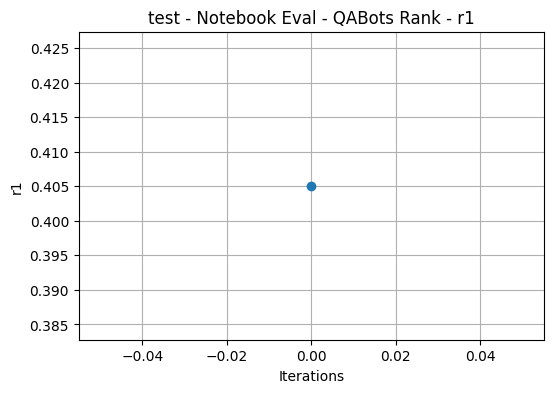

r5: 1.4437058579144162


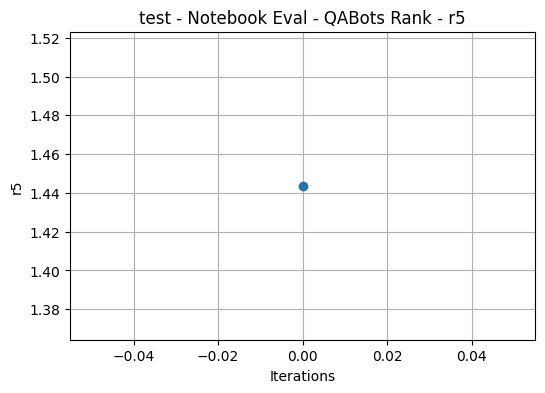

r10: 2.7420024927295388


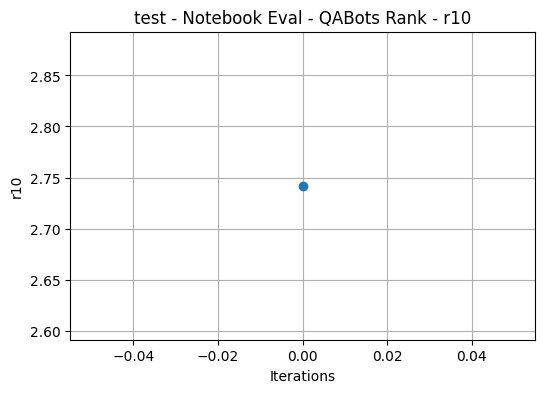

mean: 1012.3218737017033


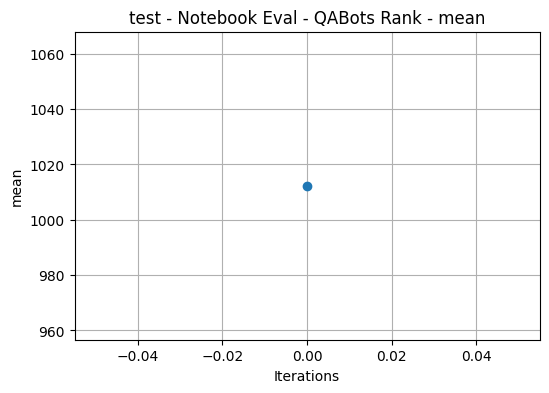

mrr: 0.01579099586109652


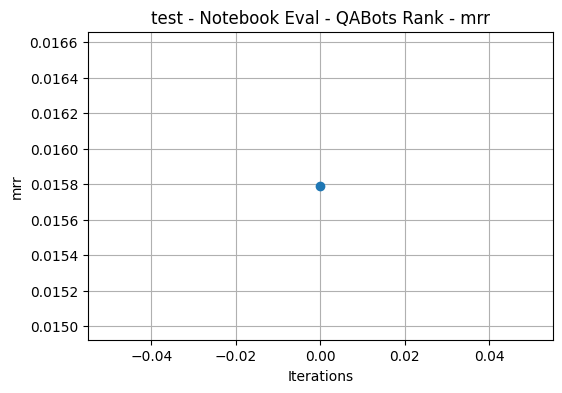

percentile: 89.48564734418672


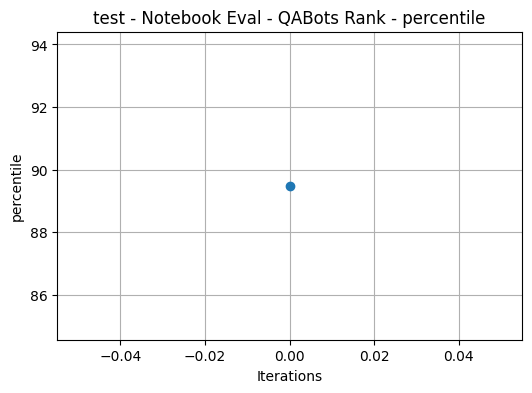

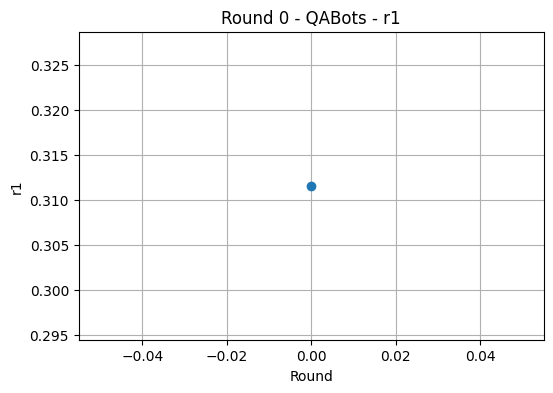

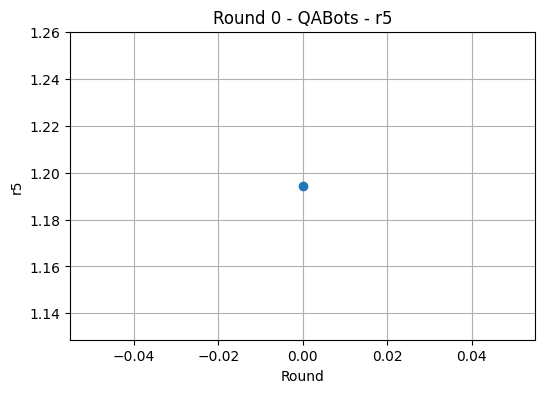

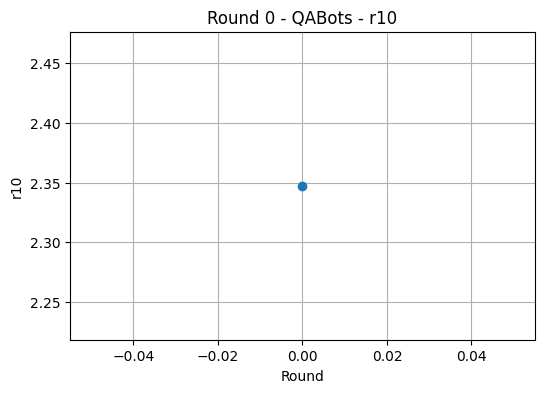

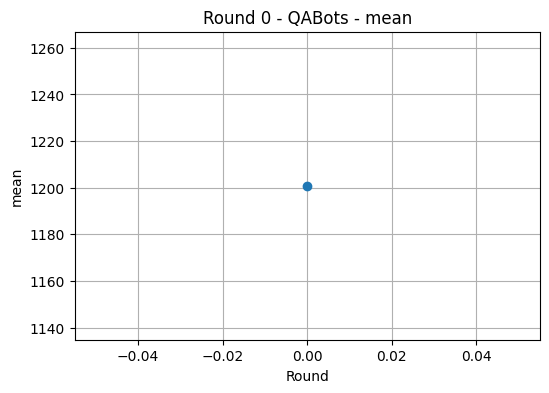

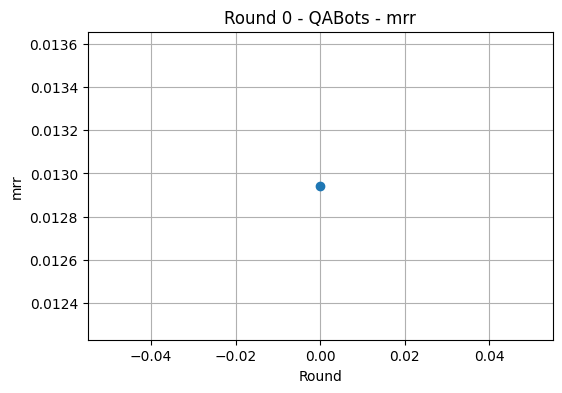

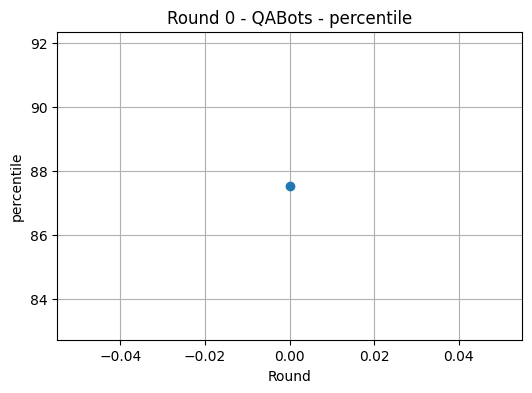

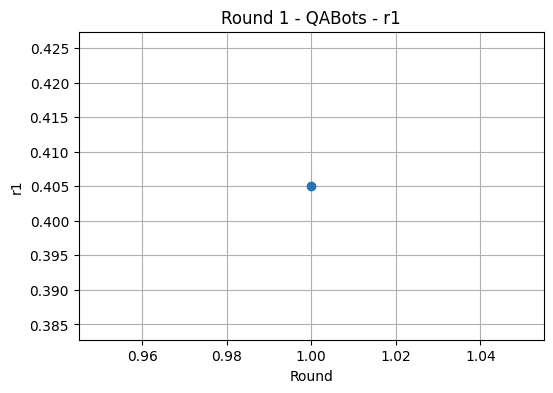

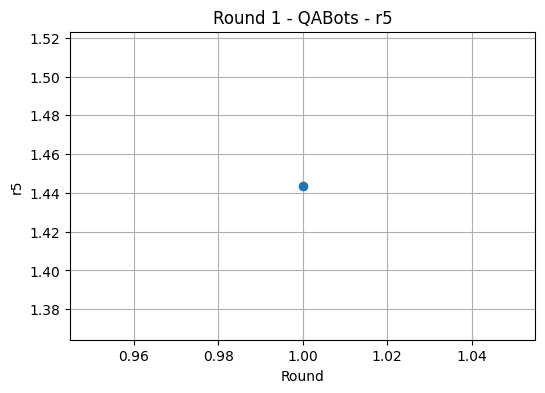

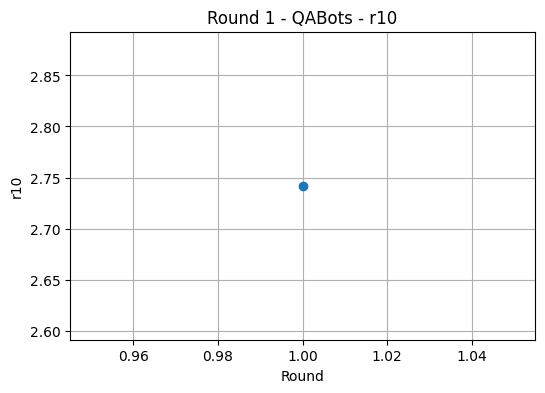

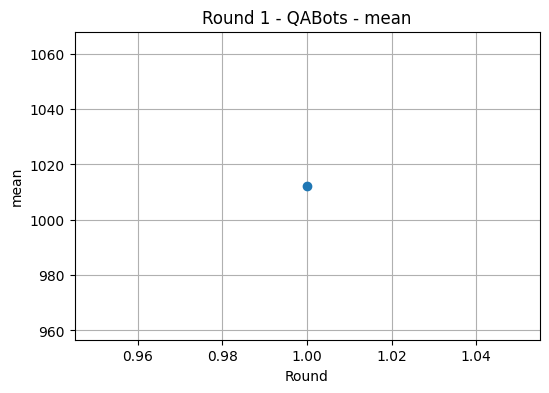

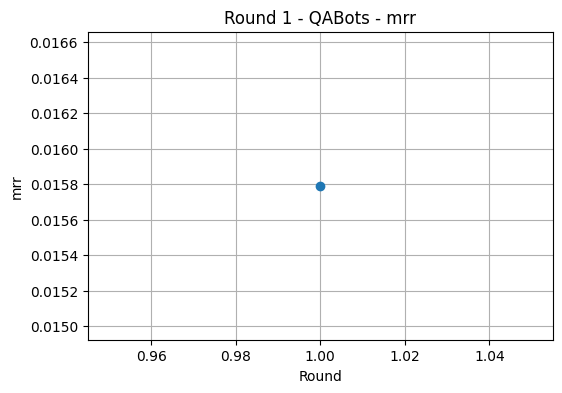

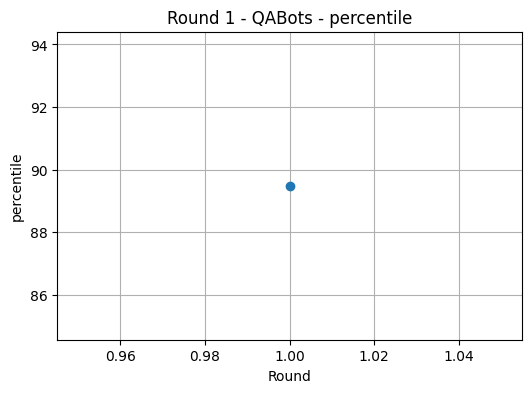

In [ ]:
# Evaluate Joint Q&A Bots Ranking
if 'QABotsRank' in params['evalModeList']:
    print("\nPerforming QABotsRank evaluation...")
    rankMetrics, roundRanks = rankQABots(qBot, aBot, dataset, split, beamSize=params['beamSize'])
    for metric, value in rankMetrics.items():
        print(f"{metric}: {value}")
        line_plot([iterId], [value], f"{splitName} - QABots Rank - {metric}", ylabel=metric)

    for r in range(numRounds + 1):
        for metric, value in roundRanks[r].items():
            line_plot([r], [value], f"Round {r} - QABots - {metric}", ylabel=metric, xlabel='Round')
    torch.cuda.empty_cache()

In [ ]:


import sys
import json
import h5py
import numpy as np
from timeit import default_timer as timer

import torch
from torch.autograd import Variable

import options
import visdial.metrics as metrics
from utils import utilities as utils
from dataloader import VisDialDataset
from torch.utils.data import DataLoader

from sklearn.metrics.pairwise import pairwise_distances

from six.moves import range


def dialogDump(params,
               dataset,
               split,
               aBot,
               qBot=None,
               beamSize=1,
               savePath="dialog_results.json"):
    assert aBot is not None or (qBot is not None and aBot is not None),\
           "Must provide either an A-Bot alone or both Q-Bot and A-Bot when generating dialog"

    old_split = dataset.split
    batchSize = dataset.batchSize  # Corrected attribute name from dataset.batchSize to dataset.batch_size
    numRounds = dataset.numRounds
    dataset.split = split
    ind2word = dataset.ind2word

    # Functions to convert tensor to string
    def to_str_gt(w):
        return " ".join([ind2word[x.item()] for x in w.data.cpu().numpy() if x > 0])

    def to_str_pred(w, l):
        length = l.item()  # Convert length tensor to Python scalar
        return " ".join([ind2word[x.item()] for x in w.data.cpu().numpy()[:length] if x > 0])

    dataloader = DataLoader(
        dataset,
        batch_size=batchSize,
        shuffle=False,
        num_workers=0,
        collate_fn=dataset.collate_fn)
    print(1)
    text = {'data': []}
    if '%s_img_fnames' % split not in dataset.data.keys():
        print('%s_img_fnames' % split)
        print("[Error] Need coco directory and info as input " \
               "to -cocoDir and -cocoInfo arguments for locating "\
               "coco image files.")
        print("Exiting dialogDump without saving files.")
        return None

    getImgFileName = lambda x: dataset.data['%s_img_fnames' % split][x]
    getImgId = lambda x: int(getImgFileName(x)[:-4][-12:])

    for idx, batch in enumerate(dataloader):
        if idx > 3:
            break
        imgIds = [getImgId(x) for x in batch['index']]
        dialog = [{'dialog': [], 'image_id': imgId} for imgId in imgIds]

        if dataset.useGPU:
            batch = {key: v.cuda() if isinstance(v, torch.Tensor) else v for key, v in batch.items()}

        image = Variable(batch['img_feat'], volatile=True)
        caption = Variable(batch['cap'], volatile=True)
        captionLens = Variable(batch['cap_len'], volatile=True)
        if qBot is None:  # A-Bot alone needs ground truth dialog
            gtQuestions = Variable(batch['ques'], volatile=True)
            gtQuesLens = Variable(batch['ques_len'], volatile=True)
            gtAnswers = Variable(batch['ans'], volatile=True)
            gtAnsLens = Variable(batch['ans_len'], volatile=True)

        if aBot:
            aBot.eval(), aBot.reset()
            aBot.observe(
                -1, image=image, caption=caption, captionLens=captionLens)
        if qBot:
            qBot.eval(), qBot.reset()
            qBot.observe(-1, caption=caption, captionLens=captionLens)
        questions = []

        for j in range(batchSize):
            caption_str = to_str_gt(caption[j])[8:-6]
            dialog[j]['caption'] = caption_str

        for round in range(numRounds):
            if aBot is not None and qBot is None:
                aBot.observe(
                    round,
                    ques=gtQuestions[:, round],
                    quesLens=gtQuesLens[:, round])
                aBot.observe(
                    round,
                    ans=gtAnswers[:, round],
                    ansLens=gtAnsLens[:, round])
                _ = aBot.forward()
                answers, ansLens = aBot.forwardDecode(
                    inference='greedy', beamSize=beamSize)

            elif aBot is not None and qBot is not None:
                questions, quesLens = qBot.forwardDecode(
                    beamSize=beamSize, inference='greedy')
                qBot.observe(round, ques=questions, quesLens=quesLens)
                aBot.observe(round, ques=questions, quesLens=quesLens)
                answers, ansLens = aBot.forwardDecode(
                    beamSize=beamSize, inference='greedy')
                aBot.observe(round, ans=answers, ansLens=ansLens)
                qBot.observe(round, ans=answers, ansLens=ansLens)

            for j in range(batchSize):
                if qBot is not None:
                    question_str = to_str_pred(questions[j], quesLens[j])
                else:
                    question_str = to_str_gt(gtQuestions[j])

                answer_str = to_str_pred(answers[j], ansLens[j])

                dialog[j]['dialog'].append({
                    "answer": answer_str[8:],
                    "question": question_str[8:] + " "
                })  # "8:" for indexing out initial <START>
        text['data'].extend(dialog)

    text['opts'] = {
        'qbot': params['qstartFrom'],
        'abot': params['startFrom'],
        'backend': 'cudnn',
        'beamLen': 20,
        'beamSize': beamSize,
        'decoder': params['decoder'],
        'encoder': params['encoder'],
        'gpuid': 0,
        'imgNorm': params['imgNorm'],
        'inputImg': params['inputImg'],
        'inputJson': params['inputJson'],
        'inputQues': params['inputQues'],
        'loadPath': 'checkpoints/',
        'maxThreads': 1,
        'resultPath': 'dialog_output/results',
        'sampleWords': 0,
        'temperature': 1,
        'useHistory': True,
        'useIm': True,
    }
    with open(savePath, "w") as fp:
        print("Writing dialog text data to file: {}".format(savePath))
        json.dump(text, fp)
    print("Done!")

    dataset.split = old_split
    return







# Dialog Generation
if 'dialog' in params['evalModeList']:
    print("\nPerforming dialog generation...")
    outputFolder = "dialog_output/results"
    os.makedirs(outputFolder, exist_ok=True)
    outputPath = os.path.join(outputFolder, "results6.json")

    dialogDump(params, dataset, split, aBot=aBot, qBot=qBot,
               beamSize=params['beamSize'], savePath=outputPath)
    print("Dialog generation complete!")
    torch.cuda.empty_cache()

print("\nEvaluation run complete!")



Performing dialog generation...
1


<ipython-input-34-15a3a085cb25>:73: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(batch['img_feat'], volatile=True)
<ipython-input-34-15a3a085cb25>:74: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  caption = Variable(batch['cap'], volatile=True)
<ipython-input-34-15a3a085cb25>:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  captionLens = Variable(batch['cap_len'], volatile=True)


Writing dialog text data to file: dialog_output/results/results6.json
Done!
Dialog generation complete!

Evaluation run complete!


In [ ]:
with open("/content/drive/MyDrive/visdial-rl/dialog_output/results/results6.json", "r") as f:
    data = json.load(f)

with open("/content/drive/MyDrive/visdial-rl/dialog_output/results/resultsss.json", "w") as f:
    json.dump(data, f, indent=2)